## Machine Learning on Spatial Transcriptomics Data

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

In [2]:
# Load gene expression values from AnnData object
adata = sc.read("preprocessed_mouse.h5ad")

In [3]:
adata.obs

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_counts,clusters
AAACAAGTATCTCCCA-1,1,50,102,4462,8.403576,13991.0,9.546241,25.523551,31.748981,40.132943,54.113359,1521.0,7.327781,10.871274,13989.0,3
AAACACCAATAACTGC-1,1,59,19,8126,9.002947,39797.0,10.591572,20.760359,26.132623,33.768877,47.144257,3977.0,8.288534,9.993216,39779.0,5
AAACAGAGCGACTCCT-1,1,14,94,6526,8.783703,29951.0,10.307351,28.423091,33.611566,40.749891,53.193549,4265.0,8.358432,14.239925,29945.0,2
AAACAGCTTTCAGAAG-1,1,43,9,8190,9.010791,42333.0,10.653346,15.659178,21.760801,30.030945,44.157041,2870.0,7.962416,6.779581,42325.0,6
AAACAGGGTCTATATT-1,1,47,13,8090,8.998508,35700.0,10.482934,13.196078,18.985994,27.165266,40.963585,1831.0,7.513164,5.128851,35692.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTGTTTCCCGAAAG-1,1,51,59,6754,8.818038,29112.0,10.278940,21.856966,27.881973,36.040121,49.920995,2916.0,7.978311,10.016488,29105.0,0
TTGTTCAGTGTGCTAC-1,1,24,64,6586,8.792853,30918.0,10.339127,25.726114,31.389482,39.058154,52.183194,4428.0,8.395929,14.321754,30913.0,2
TTGTTGTGTGTCAAGA-1,1,31,77,5973,8.695172,23779.0,10.076600,22.915177,29.269524,37.756003,51.848269,2538.0,7.839526,10.673283,23774.0,0
TTGTTTCACATCCAGG-1,1,58,42,4604,8.434898,17928.0,9.794175,40.980589,46.290718,52.794511,63.492860,4475.0,8.406485,24.960955,17924.0,4


In [4]:
# Convert the last column of adata.obs to labels
labels = adata.obs.iloc[:, -1].values
labels

['3', '5', '2', '6', '6', ..., '0', '2', '0', '4', '3']
Length: 2500
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']

In [5]:
# Encode the labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
y

array([3, 5, 2, ..., 0, 4, 3])

In [6]:
# Remove the last column (assuming it contains cluster IDs)
adata.obs = adata.obs.drop(adata.obs.columns[-1], axis=1)
adata.obs

,in_tissue,array_row,array_col,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,n_counts
AAACAAGTATCTCCCA-1,1,50,102,4462,8.403576,13991.0,9.546241,25.523551,31.748981,40.132943,54.113359,1521.0,7.327781,10.871274,13989.0
AAACACCAATAACTGC-1,1,59,19,8126,9.002947,39797.0,10.591572,20.760359,26.132623,33.768877,47.144257,3977.0,8.288534,9.993216,39779.0
AAACAGAGCGACTCCT-1,1,14,94,6526,8.783703,29951.0,10.307351,28.423091,33.611566,40.749891,53.193549,4265.0,8.358432,14.239925,29945.0
AAACAGCTTTCAGAAG-1,1,43,9,8190,9.010791,42333.0,10.653346,15.659178,21.760801,30.030945,44.157041,2870.0,7.962416,6.779581,42325.0
AAACAGGGTCTATATT-1,1,47,13,8090,8.998508,35700.0,10.482934,13.196078,18.985994,27.165266,40.963585,1831.0,7.513164,5.128851,35692.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTGTTTCCCGAAAG-1,1,51,59,6754,8.818038,29112.0,10.278940,21.856966,27.881973,36.040121,49.920995,2916.0,7.978311,10.016488,29105.0
TTGTTCAGTGTGCTAC-1,1,24,64,6586,8.792853,30918.0,10.339127,25.726114,31.389482,39.058154,52.183194,4428.0,8.395929,14.321754,30913.0
TTGTTGTGTGTCAAGA-1,1,31,77,5973,8.695172,23779.0,10.076600,22.915177,29.269524,37.756003,51.848269,2538.0,7.839526,10.673283,23774.0
TTGTTTCACATCCAGG-1,1,58,42,4604,8.434898,17928.0,9.794175,40.980589,46.290718,52.794511,63.492860,4475.0,8.406485,24.960955,17924.0


In [7]:
X = adata.X

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [8]:
# Define the neural network model
class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
# Initialize the model, optimizer, and loss function
input_dim = X_train.shape[1]  # Assuming X_train is a dense matrix
num_classes = len(np.unique(y_train))
model = Classifier(input_dim, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

## Assess model performance with F1 score

In [10]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.long())  # Convert labels to long data type explicitly
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total

    return train_loss, train_accuracy

In [11]:
def evaluate(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    eval_loss = running_loss / len(data_loader)
    eval_accuracy = 100. * correct / total
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    return eval_loss, eval_accuracy, f1

In [16]:
def train_with_cv(X_train, y_train, X_val, y_val, criterion, num_epochs, batch_size, num_folds=5):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    best_model_state_dict = None
    best_performance = 0.0
    best_f1_score = 0.0

    fold_train_losses = []
    fold_val_losses = []
    fold_train_f1_scores = []
    fold_val_f1_scores = []

    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train)):
        X_fold_train, y_fold_train = X_train[train_index], y_train[train_index]
        X_fold_val, y_fold_val = X_train[val_index], y_train[val_index]

        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_fold_train.toarray()), torch.tensor(y_fold_train))
        val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_fold_val.toarray()), torch.tensor(y_fold_val))

        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

        print(f"Fold {fold+1}/{skf.get_n_splits()}")

        # Initialize the model with random hyperparameters
        model = Classifier(input_dim=X_train.shape[1], num_classes=len(np.unique(y_train)))
        
        # Sample a random learning rate from a predefined range (e.g., uniform distribution)
        lr_min, lr_max = 0.0001, 0.01
        lr = np.random.uniform(lr_min, lr_max)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model
        train_losses = []
        val_losses = []
        train_f1_scores = []
        val_f1_scores = []

        for epoch in range(num_epochs):
            train_loss, _ = train(model, train_loader, optimizer, criterion)
            val_loss, val_accuracy, val_f1 = evaluate(model, val_loader, criterion)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_f1_scores.append(val_f1)  # Note: Use validation F1 score here
            val_f1_scores.append(val_f1)

            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val F1 Score: {val_f1:.4f}")

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        fold_train_f1_scores.append(train_f1_scores)
        fold_val_f1_scores.append(val_f1_scores)

        # If current model has better performance, update best_model_state_dict
        if np.mean(val_f1_scores) > best_performance:
            best_performance = np.mean(val_f1_scores)
            best_model_state_dict = model.state_dict()
            best_f1_score = np.mean(val_f1_scores)

    return best_model_state_dict, fold_train_losses, fold_val_losses, fold_train_f1_scores, fold_val_f1_scores

In [17]:
def test_model(model, X_test, y_test, criterion):
    test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test.toarray()), torch.tensor(y_test))
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8)
    
    test_loss, test_accuracy, test_f1 = evaluate(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test F1 Score: {test_f1:.4f}")
    
    return test_loss, test_accuracy, test_f1

In [18]:
# Plotting the performances
def plot_performance(train_losses, val_losses, fold_f1_scores):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, fold_f1_scores, label='F1 Score')
    plt.title('F1 Score Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [19]:
# Define the hyperparameters
num_epochs = 10
batch_size = 8
num_folds = 5

# Train the model with dynamic hyperparameter tuning
best_model_state_dict, fold_train_losses, fold_val_losses, fold_train_f1_scores, fold_val_f1_scores = train_with_cv(X_train, y_train, X_val, y_val, criterion, num_epochs, batch_size, num_folds)

Fold 1/5
Epoch 1/10, Train Loss: 0.9822, Val Loss: 0.5510, Val F1 Score: 0.7555
Epoch 2/10, Train Loss: 0.1770, Val Loss: 0.4730, Val F1 Score: 0.8634
Epoch 3/10, Train Loss: 0.0352, Val Loss: 0.1219, Val F1 Score: 0.9595
Epoch 4/10, Train Loss: 0.0044, Val Loss: 0.1009, Val F1 Score: 0.9622
Epoch 5/10, Train Loss: 0.0017, Val Loss: 0.1162, Val F1 Score: 0.9560
Epoch 6/10, Train Loss: 0.0011, Val Loss: 0.1269, Val F1 Score: 0.9528
Epoch 7/10, Train Loss: 0.0006, Val Loss: 0.1158, Val F1 Score: 0.9560
Epoch 8/10, Train Loss: 0.0004, Val Loss: 0.1246, Val F1 Score: 0.9496
Epoch 9/10, Train Loss: 0.0003, Val Loss: 0.1227, Val F1 Score: 0.9560
Epoch 10/10, Train Loss: 0.0002, Val Loss: 0.1269, Val F1 Score: 0.9496
Fold 2/5
Epoch 1/10, Train Loss: 1.1878, Val Loss: 0.4550, Val F1 Score: 0.8115
Epoch 2/10, Train Loss: 0.2534, Val Loss: 0.3764, Val F1 Score: 0.8758
Epoch 3/10, Train Loss: 0.0393, Val Loss: 0.1875, Val F1 Score: 0.9345
Epoch 4/10, Train Loss: 0.2053, Val Loss: 0.4558, Val F1 S

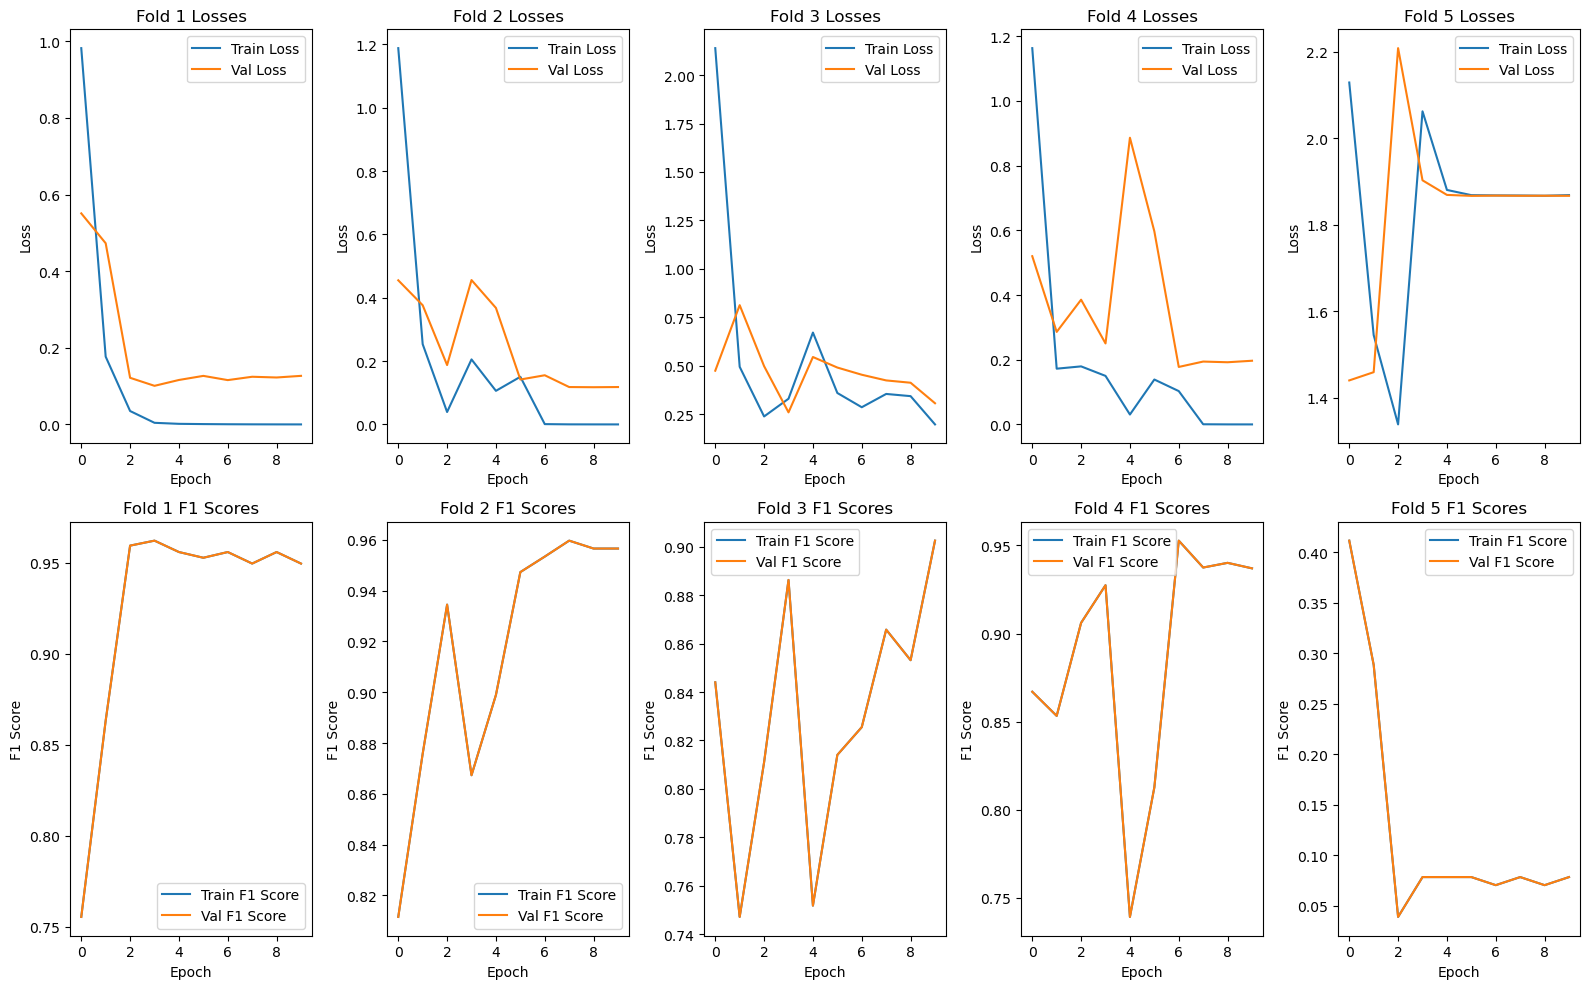

In [20]:
# Plotting the performances
plt.figure(figsize=(16, 10))

for fold in range(num_folds):
    plt.subplot(2, num_folds, fold + 1)
    plt.plot(fold_train_losses[fold], label='Train Loss')
    plt.plot(fold_val_losses[fold], label='Val Loss')
    plt.title(f'Fold {fold+1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, num_folds, fold + 1 + num_folds)
    plt.plot(fold_train_f1_scores[fold], label='Train F1 Score')
    plt.plot(fold_val_f1_scores[fold], label='Val F1 Score')
    plt.title(f'Fold {fold+1} F1 Scores')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Create and evaluate the best model on the test set
best_model = Classifier(input_dim=X_train.shape[1], num_classes=len(np.unique(y_train)))
best_model.load_state_dict(best_model_state_dict)

criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy, test_f1 = test_model(best_model, X_test, y_test, criterion)

Test Loss: 0.1269, Test Accuracy: 95.60%, Test F1 Score: 0.9553
